# HumanEva Dataset Analysis

This notebook analyzes the HumanEva-I motion capture dataset for the HumanMAC implementation.

**Objectives:**
- Load and inspect data structure
- Extract skeleton information (15 joints)
- Compute statistics and quality metrics
- Visualize motion sequences
- Export metadata for project use

**Dataset Files:**
- `data_3d_humaneva15.npz` - Training data
- `data_3d_humaneva15_test.npz` - Test data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Data paths
data_dir = Path('../data')
train_file = data_dir / 'data_3d_humaneva15.npz'
test_file = data_dir / 'data_3d_humaneva15_test.npz'

print(f"Train file exists: {train_file.exists()}")
print(f"Test file exists: {test_file.exists()}")

Train file exists: True
Test file exists: True


### Load NPZ Files
Load training and test data, inspect keys and structure.

In [2]:
# Load training data
train_data = np.load(train_file, allow_pickle=True)

print("Available keys in training data:")
print(train_data.keys())
print("\n" + "="*50)

# Convert keys to list for better display
keys_list = list(train_data.keys())

print(f"Number of keys: {len(keys_list)}")
print("\nKey names:")
for i, key in enumerate(keys_list, 1):
    print(f"{i}. {key}")
    print(f"Data type: {type(train_data[key])}")
    print(f"Shape: {train_data[key].shape}")
    print(f"Dtype: {train_data[key].dtype}\n")

Available keys in training data:
KeysView(<numpy.lib.npyio.NpzFile object at 0x7047cc099430>)

Number of keys: 1

Key names:
1. positions_3d
Data type: <class 'numpy.ndarray'>
Shape: ()
Dtype: object



In [3]:
# Check if it's an object array with nested structure
if train_data[keys_list[0]].dtype == object:
    print("="*50)
    print("This is an object array. Inspecting first element...")
    
    first_elem = train_data[keys_list[0]][()]
    print(f"Type of first element: {type(first_elem)}")
    
    if isinstance(first_elem, dict):
        print(f"\nDictionary keys: {list(first_elem.keys())}")
        print(f"Number of subjects/categories: {len(first_elem)}")

This is an object array. Inspecting first element...
Type of first element: <class 'dict'>

Dictionary keys: ['Train/S1', 'Train/S2', 'Train/S3', 'Validate/S1', 'Validate/S2', 'Validate/S3']
Number of subjects/categories: 6


In [4]:
# Extract the main data dictionary
data_dict = train_data['positions_3d'][()]

# Get subjects
subjects = sorted(data_dict.keys())
print(f"Subjects in training data: {subjects}")
print(f"Number of subjects: {len(subjects)}")

# Explore structure for first subject
first_subject = subjects[0]
print(f"\nExploring subject: {first_subject}")
print(f"Actions: {list(data_dict[first_subject].keys())}")

# Get all unique actions across subjects
all_actions = set()
for subject in subjects:
    all_actions.update(data_dict[subject].keys())

all_actions = sorted(all_actions)
print(f"\nAll unique actions: {all_actions}")
print(f"Total unique actions: {len(all_actions)}")

Subjects in training data: ['Train/S1', 'Train/S2', 'Train/S3', 'Validate/S1', 'Validate/S2', 'Validate/S3']
Number of subjects: 6

Exploring subject: Train/S1
Actions: ['Box 1 chunk1', 'Box 1 chunk3', 'Box 1 chunk5', 'Box 1 chunk7', 'Gestures 1 chunk0', 'Jog 1 chunk1', 'Jog 1 chunk3', 'ThrowCatch 1 chunk1', 'Walking 1 chunk0']

All unique actions: ['Box 1 chunk0', 'Box 1 chunk1', 'Box 1 chunk10', 'Box 1 chunk12', 'Box 1 chunk2', 'Box 1 chunk3', 'Box 1 chunk4', 'Box 1 chunk5', 'Box 1 chunk6', 'Box 1 chunk7', 'Box 1 chunk8', 'Gestures 1 chunk0', 'Gestures 1 chunk1', 'Gestures 1 chunk2', 'Gestures 1 chunk3', 'Gestures 1 chunk4', 'Gestures 1 chunk5', 'Gestures 1 chunk6', 'Gestures 1 chunk7', 'Gestures 1 chunk8', 'Gestures 1 chunk9', 'Jog 1 chunk0', 'Jog 1 chunk1', 'Jog 1 chunk2', 'Jog 1 chunk3', 'Jog 1 chunk4', 'ThrowCatch 1 chunk0', 'ThrowCatch 1 chunk1', 'ThrowCatch 1 chunk10', 'ThrowCatch 1 chunk12', 'ThrowCatch 1 chunk2', 'ThrowCatch 1 chunk3', 'ThrowCatch 1 chunk4', 'ThrowCatch 1 chu

In [5]:
# Inspect a sample sequence
sample_subject = subjects[0]
sample_action = list(data_dict[sample_subject].keys())[0]
sample_sequence = data_dict[sample_subject][sample_action]

print(f"Sample: {sample_subject} - {sample_action}")
print(f"Sequence shape: {sample_sequence.shape}")
print(f"  Frames: {sample_sequence.shape[0]}")
print(f"  Joints: {sample_sequence.shape[1]}")
print(f"  Coordinates: {sample_sequence.shape[2]} (X, Y, Z)")

# Show first few frames
print(f"\nFirst 3 frames of first joint:")
print(sample_sequence[:3, 0, :])

Sample: Train/S1 - Box 1 chunk1
Sequence shape: (28, 15, 3)
  Frames: 28
  Joints: 15
  Coordinates: 3 (X, Y, Z)

First 3 frames of first joint:
[[-0.33715054  0.12879056  0.8658128 ]
 [-0.3345422   0.12813617  0.8654417 ]
 [-0.33169472  0.12751755  0.8654423 ]]


## Dataset Stats Overview
Count sequences, compute lengths, and summarize dataset composition.

In [6]:
# Count sequences for train and validation splits
train_sequences = {}
val_sequences = {}

for subject in subjects:
    if subject.startswith('Train/'):
        train_sequences[subject] = len(data_dict[subject])
    elif subject.startswith('Validate/'):
        val_sequences[subject] = len(data_dict[subject])

total_train = sum(train_sequences.values())
total_val = sum(val_sequences.values())

print("Training Split:")
for subj, count in train_sequences.items():
    print(f"  {subj}: {count} sequences")
print(f"Total Training: {total_train} sequences\n")

print("Validation Split:")
for subj, count in val_sequences.items():
    print(f"  {subj}: {count} sequences")
print(f"Total Validation: {total_val} sequences\n")

print(f"Overall Total: {total_train + total_val} sequences")

Training Split:
  Train/S1: 9 sequences
  Train/S2: 13 sequences
  Train/S3: 13 sequences
Total Training: 35 sequences

Validation Split:
  Validate/S1: 11 sequences
  Validate/S2: 21 sequences
  Validate/S3: 10 sequences
Total Validation: 42 sequences

Overall Total: 77 sequences


### Extract base action categories without chunk numbers. Key variable: base_actions.

In [7]:
# Extract base action categories (without chunk numbers)
base_actions = set()
for action in all_actions:
    # Remove " chunk#" suffix
    base_action = ' '.join(action.split()[:-2])
    base_actions.add(base_action)

base_actions = sorted(base_actions)

print(f"Base action categories: {base_actions}")
print(f"Number of base actions: {len(base_actions)}")

Base action categories: ['Box', 'Gestures', 'Jog', 'ThrowCatch', 'Walking']
Number of base actions: 5


### Compute sequence length statistics across all sequences. Store lengths in sequence_lengths.

In [8]:
# Collect sequence lengths
sequence_lengths = []
sequence_info = []

for subject in subjects:
    for action, sequence in data_dict[subject].items():
        seq_len = sequence.shape[0]
        sequence_lengths.append(seq_len)
        sequence_info.append({
            'subject': subject,
            'action': action,
            'length': seq_len,
            'split': 'Train' if subject.startswith('Train/') else 'Validate'
        })

# Convert to DataFrame for easier analysis
df_sequences = pd.DataFrame(sequence_info)

print("Sequence Length Statistics:")
print(f"  Mean: {np.mean(sequence_lengths):.2f} frames")
print(f"  Median: {np.median(sequence_lengths):.2f} frames")
print(f"  Min: {np.min(sequence_lengths)} frames")
print(f"  Max: {np.max(sequence_lengths)} frames")
print(f"  Std: {np.std(sequence_lengths):.2f} frames")

Sequence Length Statistics:
  Mean: 124.38 frames
  Median: 67.00 frames
  Min: 2 frames
  Max: 613 frames
  Std: 147.91 frames


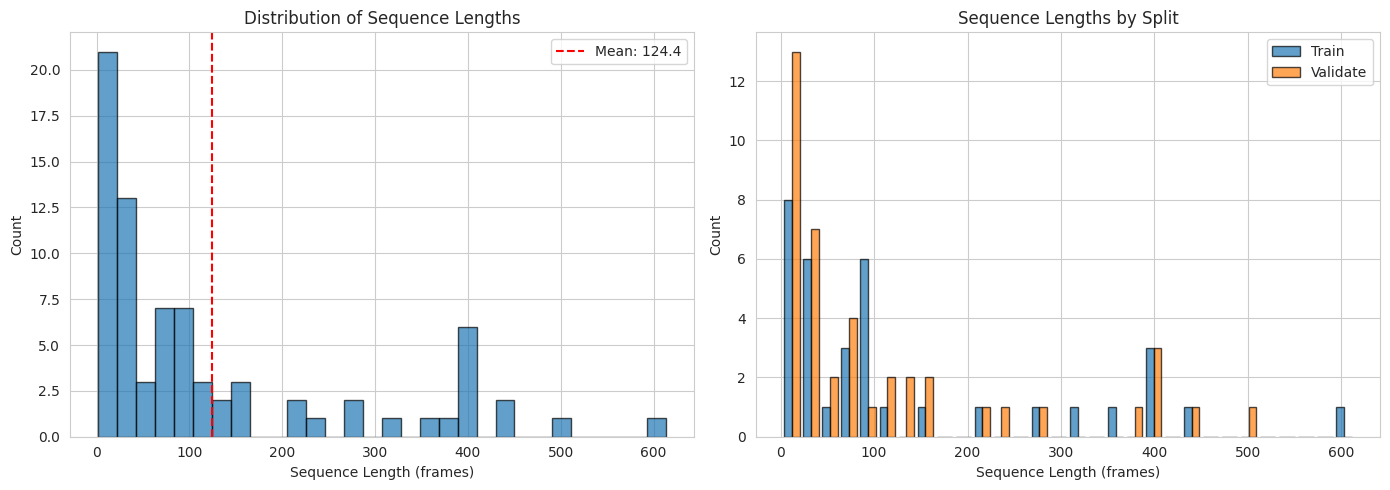

In [9]:
# Plot sequence length distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall distribution
axes[0].hist(sequence_lengths, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Sequence Length (frames)')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Sequence Lengths')
axes[0].axvline(np.mean(sequence_lengths), color='red', linestyle='--', 
                label=f'Mean: {np.mean(sequence_lengths):.1f}')
axes[0].legend()

# By split
train_lengths = df_sequences[df_sequences['split'] == 'Train']['length']
val_lengths = df_sequences[df_sequences['split'] == 'Validate']['length']

axes[1].hist([train_lengths, val_lengths], bins=30, 
             label=['Train', 'Validate'], edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Sequence Length (frames)')
axes[1].set_ylabel('Count')
axes[1].set_title('Sequence Lengths by Split')
axes[1].legend()

plt.tight_layout()
plt.show()

### Count sequences per base action category.

Sequences per base action:
  Box: 24
  Gestures: 21
  ThrowCatch: 11
  Walking: 11
  Jog: 10


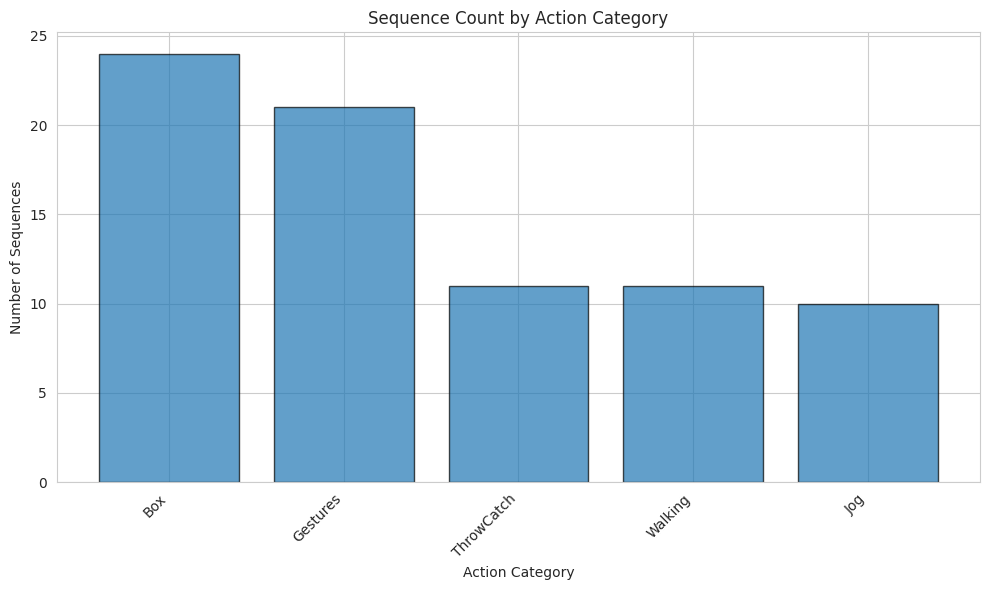

In [10]:
# Count sequences per base action
action_counts = {}
for info in sequence_info:
    base_action = ' '.join(info['action'].split()[:-2])
    action_counts[base_action] = action_counts.get(base_action, 0) + 1

action_counts = dict(sorted(action_counts.items(), key=lambda x: x[1], reverse=True))

print("Sequences per base action:")
for action, count in action_counts.items():
    print(f"  {action}: {count}")

# Plot
plt.figure(figsize=(10, 6))
plt.bar(action_counts.keys(), action_counts.values(), edgecolor='black', alpha=0.7)
plt.xlabel('Action Category')
plt.ylabel('Number of Sequences')
plt.title('Sequence Count by Action Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Data Format Documentation
Document the 15-joint skeleton structure and coordinate system used in HumanEva dataset.

### HumanEva-I 15-Joint Skeleton Structure
The HumanEva dataset uses a simplified 15-joint skeleton model for motion capture.

In [11]:
# HumanEva 15-joint skeleton structure
joint_names = [
    'Hip',           # 0
    'RHip',          # 1
    'RKnee',         # 2
    'RFoot',         # 3
    'LHip',          # 4
    'LKnee',         # 5
    'LFoot',         # 6
    'Spine',         # 7
    'Thorax',        # 8
    'Neck/Nose',     # 9
    'Head',          # 10
    'LShoulder',     # 11
    'LElbow',        # 12
    'LWrist',        # 13
    'RShoulder',     # 14
    'RElbow',        # 15 (Note: this would be index 15 if it exists)
    'RWrist'         # 16 (Note: this would be index 16 if it exists)
]

# Verify we have 15 joints (indices 0-14)
joint_names = joint_names[:15]
num_joints = len(joint_names)

print(f"Number of joints: {num_joints}")
print("\nJoint indices and names:")
for i, name in enumerate(joint_names):
    print(f"  {i:2d}: {name}")

Number of joints: 15

Joint indices and names:
   0: Hip
   1: RHip
   2: RKnee
   3: RFoot
   4: LHip
   5: LKnee
   6: LFoot
   7: Spine
   8: Thorax
   9: Neck/Nose
  10: Head
  11: LShoulder
  12: LElbow
  13: LWrist
  14: RShoulder


In [12]:
# Define skeleton connectivity (parent-child relationships)
skeleton_connections = [
    (0, 1),   # Hip -> RHip
    (1, 2),   # RHip -> RKnee
    (2, 3),   # RKnee -> RFoot
    (0, 4),   # Hip -> LHip
    (4, 5),   # LHip -> LKnee
    (5, 6),   # LKnee -> LFoot
    (0, 7),   # Hip -> Spine
    (7, 8),   # Spine -> Thorax
    (8, 9),   # Thorax -> Neck
    (9, 10),  # Neck -> Head
    (8, 11),  # Thorax -> LShoulder
    (11, 12), # LShoulder -> LElbow
    (12, 13), # LElbow -> LWrist
    (8, 14),  # Thorax -> RShoulder
]

print(f"Number of bones: {len(skeleton_connections)}")
print("\nSkeleton connections:")
for i, (parent, child) in enumerate(skeleton_connections):
    print(f"  {i+1:2d}. {joint_names[parent]:12s} -> {joint_names[child]}")

Number of bones: 14

Skeleton connections:
   1. Hip          -> RHip
   2. RHip         -> RKnee
   3. RKnee        -> RFoot
   4. Hip          -> LHip
   5. LHip         -> LKnee
   6. LKnee        -> LFoot
   7. Hip          -> Spine
   8. Spine        -> Thorax
   9. Thorax       -> Neck/Nose
  10. Neck/Nose    -> Head
  11. Thorax       -> LShoulder
  12. LShoulder    -> LElbow
  13. LElbow       -> LWrist
  14. Thorax       -> RShoulder


### Coordinate System & Temporal Information
Document coordinate units and frame rate.

In [13]:
# Collect all position data for range analysis
all_positions = []
for subject in subjects:
    for action, sequence in data_dict[subject].items():
        all_positions.append(sequence)

all_positions = np.concatenate(all_positions, axis=0)

print("Coordinate System Information:")
print(f"  Units: meters (typical for HumanEva)")
print(f"  Axes: X, Y, Z (3D Cartesian coordinates)")
print(f"  Shape: (frames, joints, coordinates)")
print(f"\nData Range Analysis:")
print(f"  X range: [{all_positions[:, :, 0].min():.3f}, {all_positions[:, :, 0].max():.3f}] m")
print(f"  Y range: [{all_positions[:, :, 1].min():.3f}, {all_positions[:, :, 1].max():.3f}] m")
print(f"  Z range: [{all_positions[:, :, 2].min():.3f}, {all_positions[:, :, 2].max():.3f}] m")

Coordinate System Information:
  Units: meters (typical for HumanEva)
  Axes: X, Y, Z (3D Cartesian coordinates)
  Shape: (frames, joints, coordinates)

Data Range Analysis:
  X range: [-1.354, 1.503] m
  Y range: [-1.368, 1.196] m
  Z range: [0.063, 1.818] m


In [14]:
# Temporal information
frame_rate = 60  # HumanEva-I typical frame rate (Hz)

print("Temporal Information:")
print(f"  Frame rate: {frame_rate} Hz")
print(f"  Time per frame: {1000/frame_rate:.2f} ms")
print(f"\nExample sequence timing:")
print(f"  Sample sequence length: {sample_sequence.shape[0]} frames")
print(f"  Duration: {sample_sequence.shape[0] / frame_rate:.2f} seconds")

Temporal Information:
  Frame rate: 60 Hz
  Time per frame: 16.67 ms

Example sequence timing:
  Sample sequence length: 28 frames
  Duration: 0.47 seconds


In [15]:
# Create summary DataFrame
format_summary = pd.DataFrame({
    'Property': [
        'Number of joints',
        'Coordinate dimensions',
        'Coordinate units',
        'Frame rate',
        'Total subjects',
        'Training subjects',
        'Validation subjects',
        'Total sequences',
        'Base action types'
    ],
    'Value': [
        num_joints,
        3,
        'meters',
        f'{frame_rate} Hz',
        len(subjects),
        len(train_sequences),
        len(val_sequences),
        total_train + total_val,
        len(base_actions)
    ]
})

print("HumanEva Dataset Format Summary:")
print("="*50)
print(format_summary.to_string(index=False))

HumanEva Dataset Format Summary:
             Property  Value
     Number of joints     15
Coordinate dimensions      3
     Coordinate units meters
           Frame rate  60 Hz
       Total subjects      6
    Training subjects      3
  Validation subjects      3
      Total sequences     77
    Base action types      5


## Missing Values & Quality Analysis
Check for missing values, NaNs, and data quality issues across sequences.

In [16]:
# Check for NaN and infinite values
has_nan = np.isnan(all_positions).any()
has_inf = np.isinf(all_positions).any()

print("Data Quality Check:")
print(f"  Contains NaN: {has_nan}")
print(f"  Contains Inf: {has_inf}")

if has_nan:
    nan_count = np.isnan(all_positions).sum()
    total_values = all_positions.size
    print(f"  NaN count: {nan_count} / {total_values} ({100*nan_count/total_values:.4f}%)")
    
if has_inf:
    inf_count = np.isinf(all_positions).sum()
    print(f"  Inf count: {inf_count}")

Data Quality Check:
  Contains NaN: False
  Contains Inf: False


In [17]:
# Check missing values per joint
missing_per_joint = {}

for joint_idx in range(num_joints):
    joint_data = all_positions[:, joint_idx, :]
    nan_count = np.isnan(joint_data).sum()
    missing_per_joint[joint_names[joint_idx]] = nan_count

print("Missing values per joint:")
for joint, count in missing_per_joint.items():
    print(f"  {joint:12s}: {count}")
    
total_missing = sum(missing_per_joint.values())
print(f"\nTotal missing values: {total_missing}")

Missing values per joint:
  Hip         : 0
  RHip        : 0
  RKnee       : 0
  RFoot       : 0
  LHip        : 0
  LKnee       : 0
  LFoot       : 0
  Spine       : 0
  Thorax      : 0
  Neck/Nose   : 0
  Head        : 0
  LShoulder   : 0
  LElbow      : 0
  LWrist      : 0
  RShoulder   : 0

Total missing values: 0


### Temporal Consistency Check
Verify temporal consistency by checking for sudden jumps in position.

In [18]:
# Check for sudden jumps in position (temporal consistency)
sudden_jumps = []

for subject in subjects:
    for action, sequence in data_dict[subject].items():
        if len(sequence) > 1:
            # Compute frame-to-frame differences
            diffs = np.diff(sequence, axis=0)
            max_diff = np.abs(diffs).max()
            
            sudden_jumps.append({
                'subject': subject,
                'action': action,
                'max_jump': max_diff,
                'length': len(sequence)
            })

df_jumps = pd.DataFrame(sudden_jumps)

print("Temporal Consistency Statistics:")
print(f"  Mean max jump: {df_jumps['max_jump'].mean():.4f} m")
print(f"  Median max jump: {df_jumps['max_jump'].median():.4f} m")
print(f"  Max jump overall: {df_jumps['max_jump'].max():.4f} m")
print(f"  Min jump: {df_jumps['max_jump'].min():.4f} m")

Temporal Consistency Statistics:
  Mean max jump: 0.0473 m
  Median max jump: 0.0393 m
  Max jump overall: 0.4638 m
  Min jump: 0.0051 m


In [19]:
# Flag sequences with large jumps (potential issues)
jump_threshold = df_jumps['max_jump'].mean() + 3 * df_jumps['max_jump'].std()
flagged_sequences = df_jumps[df_jumps['max_jump'] > jump_threshold]

print(f"Jump threshold (mean + 3*std): {jump_threshold:.4f} m")
print(f"Number of flagged sequences: {len(flagged_sequences)}")

if len(flagged_sequences) > 0:
    print("\nFlagged sequences:")
    print(flagged_sequences.to_string(index=False))
else:
    print("\nNo sequences flagged for large jumps.")

Jump threshold (mean + 3*std): 0.2091 m
Number of flagged sequences: 1

Flagged sequences:
    subject           action  max_jump  length
Validate/S3 Walking 1 chunk4  0.463821     267


### Heatmap: Missing Values by Joint
Visualize missing data patterns across joints.

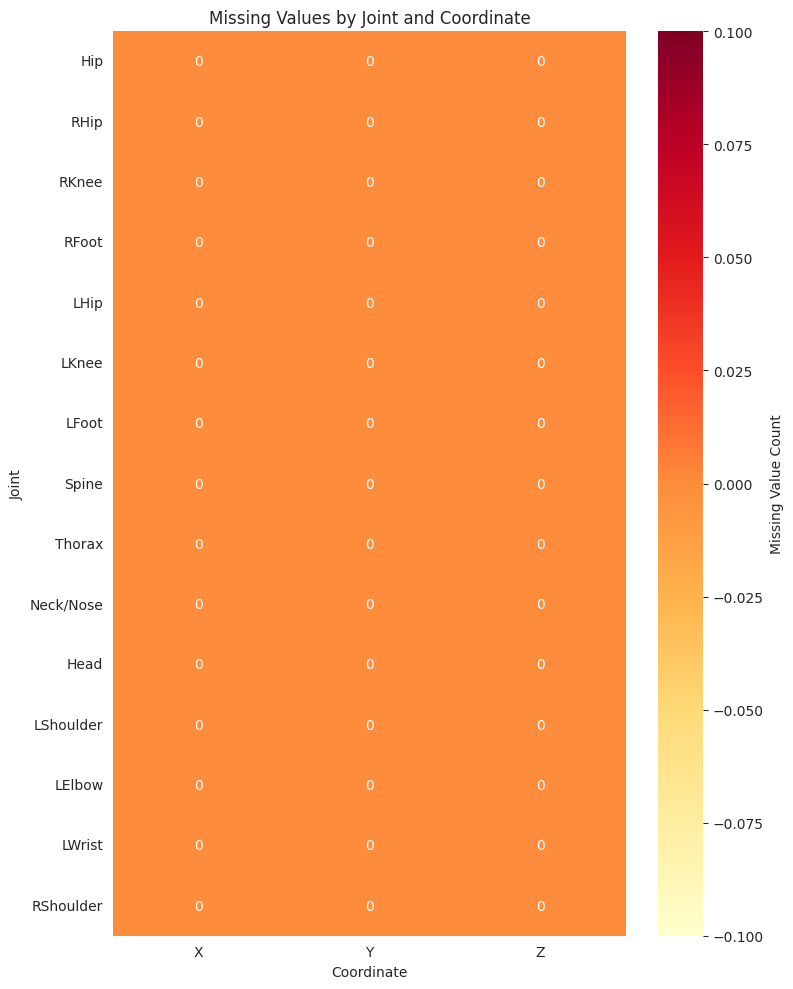

In [20]:
# Create heatmap for missing values
missing_matrix = np.zeros((num_joints, 3))

for joint_idx in range(num_joints):
    for coord_idx in range(3):
        joint_coord_data = all_positions[:, joint_idx, coord_idx]
        missing_matrix[joint_idx, coord_idx] = np.isnan(joint_coord_data).sum()

plt.figure(figsize=(8, 10))
sns.heatmap(missing_matrix, 
            annot=True, 
            fmt='.0f',
            cmap='YlOrRd',
            xticklabels=['X', 'Y', 'Z'],
            yticklabels=joint_names,
            cbar_kws={'label': 'Missing Value Count'})
plt.title('Missing Values by Joint and Coordinate')
plt.xlabel('Coordinate')
plt.ylabel('Joint')
plt.tight_layout()
plt.show()

In [21]:
# Quality summary statistics
quality_summary = {
    'Total data points': all_positions.size,
    'Missing values': np.isnan(all_positions).sum(),
    'Missing percentage': f"{100 * np.isnan(all_positions).sum() / all_positions.size:.4f}%",
    'Sequences checked': len(df_jumps),
    'Sequences with large jumps': len(flagged_sequences),
    'Max frame-to-frame jump': f"{df_jumps['max_jump'].max():.4f} m",
    'Data quality': 'Good' if total_missing == 0 and len(flagged_sequences) == 0 else 'Check flagged items'
}

print("Data Quality Summary:")
print("="*50)
for key, value in quality_summary.items():
    print(f"  {key:30s}: {value}")

Data Quality Summary:
  Total data points             : 430965
  Missing values                : 0
  Missing percentage            : 0.0000%
  Sequences checked             : 77
  Sequences with large jumps    : 1
  Max frame-to-frame jump       : 0.4638 m
  Data quality                  : Check flagged items


## Data Distribution Analysis
Analyze position distributions, ranges, and statistics across joints and actions.

In [22]:
# Compute statistics per joint
joint_stats = []

for joint_idx in range(num_joints):
    joint_data = all_positions[:, joint_idx, :]
    
    joint_stats.append({
        'Joint': joint_names[joint_idx],
        'X_mean': joint_data[:, 0].mean(),
        'X_std': joint_data[:, 0].std(),
        'Y_mean': joint_data[:, 1].mean(),
        'Y_std': joint_data[:, 1].std(),
        'Z_mean': joint_data[:, 2].mean(),
        'Z_std': joint_data[:, 2].std(),
        'X_range': joint_data[:, 0].max() - joint_data[:, 0].min(),
        'Y_range': joint_data[:, 1].max() - joint_data[:, 1].min(),
        'Z_range': joint_data[:, 2].max() - joint_data[:, 2].min()
    })

joint_stats_df = pd.DataFrame(joint_stats)
print("Per-Joint Statistics:")
print(joint_stats_df.to_string(index=False))

Per-Joint Statistics:
    Joint    X_mean    X_std    Y_mean    Y_std   Z_mean    Z_std  X_range  Y_range  Z_range
      Hip  0.016984 0.509873 -0.041590 0.454848 0.892841 0.038806 2.245080 2.037654 0.291152
     RHip  0.033879 0.486949 -0.037933 0.433515 1.367839 0.073715 2.155418 1.914691 0.385651
    RKnee  0.007495 0.419491  0.022815 0.357575 1.354338 0.071512 1.816099 1.568553 0.401828
    RFoot  0.012290 0.417977  0.039031 0.357837 1.093025 0.083835 1.774653 1.494461 0.713090
     LHip  0.082784 0.424593  0.039040 0.372974 0.980298 0.184033 2.009262 1.916353 0.956028
    LKnee  0.032129 0.577293 -0.109813 0.536996 1.353466 0.078199 2.523760 2.311308 0.355410
    LFoot  0.069121 0.618146 -0.132838 0.572287 1.122905 0.093493 2.666871 2.463647 0.636022
    Spine  0.142069 0.641521 -0.118800 0.594822 1.041065 0.230281 2.834266 2.556087 1.054137
   Thorax  0.034199 0.489241 -0.019665 0.434272 0.880580 0.037879 2.206160 1.976134 0.287930
Neck/Nose  0.010366 0.489199  0.023122 0.428762 

### Box Plots: Position Ranges for Key Joints
Visualize position distributions for selected key joints.

In [23]:
# Select key joints for visualization
key_joints = ['Hip', 'Head', 'LWrist', 'RFoot', 'LShoulder']
key_joint_indices = [joint_names.index(j) for j in key_joints if j in joint_names]

print(f"Selected joints for visualization: {key_joints}")
print(f"Indices: {key_joint_indices}")

Selected joints for visualization: ['Hip', 'Head', 'LWrist', 'RFoot', 'LShoulder']
Indices: [0, 10, 13, 3, 11]


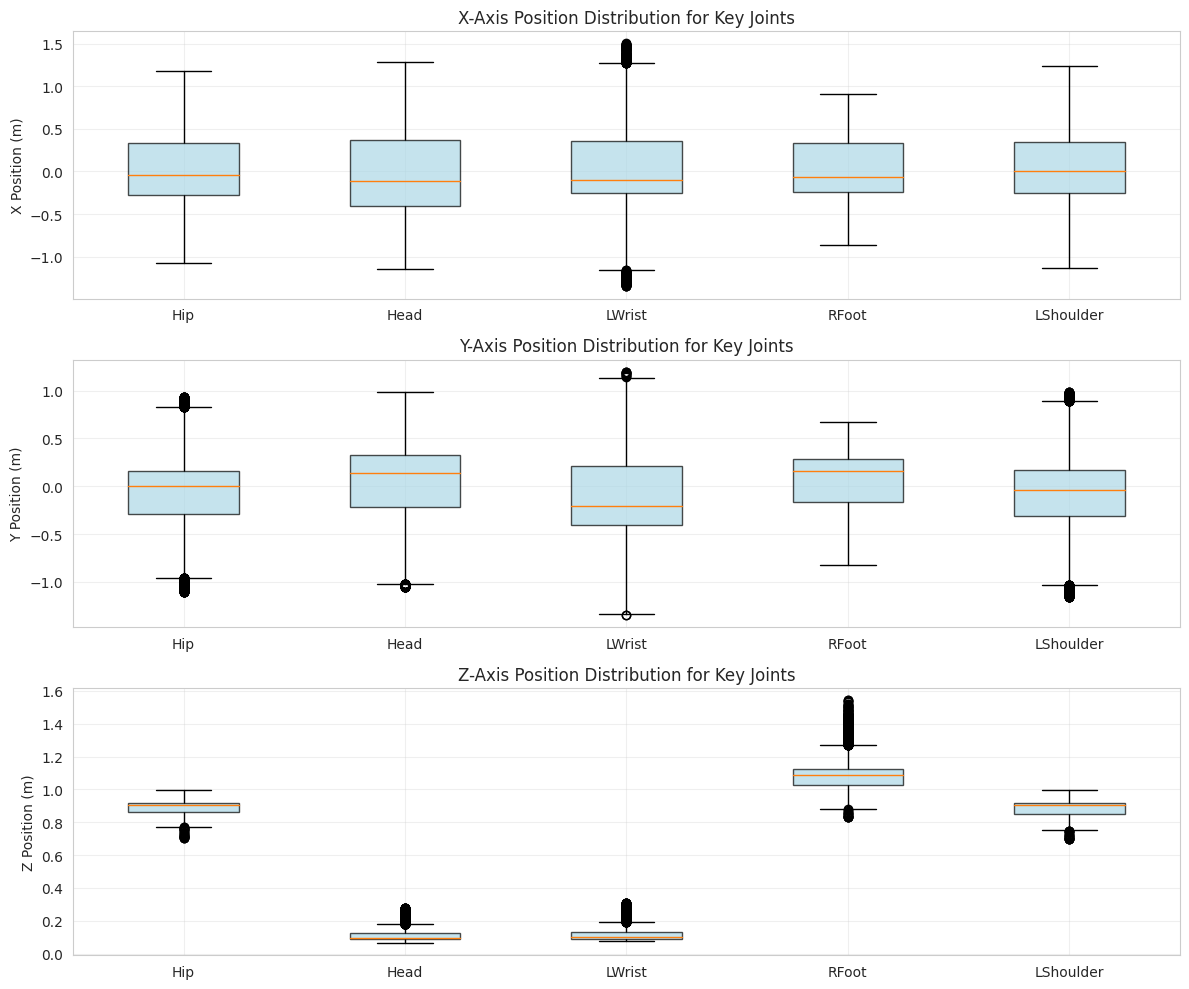

In [24]:
# Create box plots for key joints
fig, axes = plt.subplots(3, 1, figsize=(12, 10))
coords = ['X', 'Y', 'Z']

for coord_idx, (ax, coord_name) in enumerate(zip(axes, coords)):
    data_to_plot = [all_positions[:, joint_idx, coord_idx] 
                    for joint_idx in key_joint_indices]
    
    bp = ax.boxplot(data_to_plot, labels=key_joints, patch_artist=True)
    
    # Color boxes
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)
    
    ax.set_ylabel(f'{coord_name} Position (m)')
    ax.set_title(f'{coord_name}-Axis Position Distribution for Key Joints')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Velocity Statistics Analysis
Compute velocity statistics from position differences.

In [25]:
# Compute velocities (frame-to-frame differences)
all_velocities = []

for subject in subjects:
    for action, sequence in data_dict[subject].items():
        if len(sequence) > 1:
            velocities = np.diff(sequence, axis=0)
            all_velocities.append(velocities)

all_velocities = np.concatenate(all_velocities, axis=0)

print(f"Velocity data shape: {all_velocities.shape}")
print(f"Total velocity frames: {all_velocities.shape[0]}")

Velocity data shape: (9500, 15, 3)
Total velocity frames: 9500


In [26]:
# Compute velocity magnitudes
velocity_magnitudes = np.linalg.norm(all_velocities, axis=2)

# Per-joint velocity statistics
velocity_stats = []

for joint_idx in range(num_joints):
    joint_vel = velocity_magnitudes[:, joint_idx]
    
    velocity_stats.append({
        'Joint': joint_names[joint_idx],
        'Mean_vel': joint_vel.mean(),
        'Std_vel': joint_vel.std(),
        'Max_vel': joint_vel.max(),
        'Median_vel': np.median(joint_vel)
    })

velocity_stats_df = pd.DataFrame(velocity_stats)
print("Velocity Statistics (m/frame):")
print(velocity_stats_df.to_string(index=False))

Velocity Statistics (m/frame):
    Joint  Mean_vel  Std_vel  Max_vel  Median_vel
      Hip  0.010650 0.008285 0.116379    0.010193
     RHip  0.010488 0.007335 0.097464    0.010565
    RKnee  0.009400 0.006353 0.032214    0.008917
    RFoot  0.012069 0.010788 0.089707    0.009827
     LHip  0.014696 0.012204 0.132538    0.012332
    LKnee  0.012705 0.008637 0.035353    0.013313
    LFoot  0.017302 0.013225 0.121767    0.015590
    Spine  0.019981 0.014190 0.147769    0.017680
   Thorax  0.010253 0.008012 0.117742    0.009419
Neck/Nose  0.009892 0.010231 0.046981    0.006297
     Head  0.010959 0.015233 0.070494    0.002807
LShoulder  0.011144 0.008610 0.139438    0.010749
   LElbow  0.011897 0.012258 0.056737    0.007208
   LWrist  0.012720 0.017831 0.073721    0.002286
RShoulder  0.010864 0.009382 0.511920    0.010950


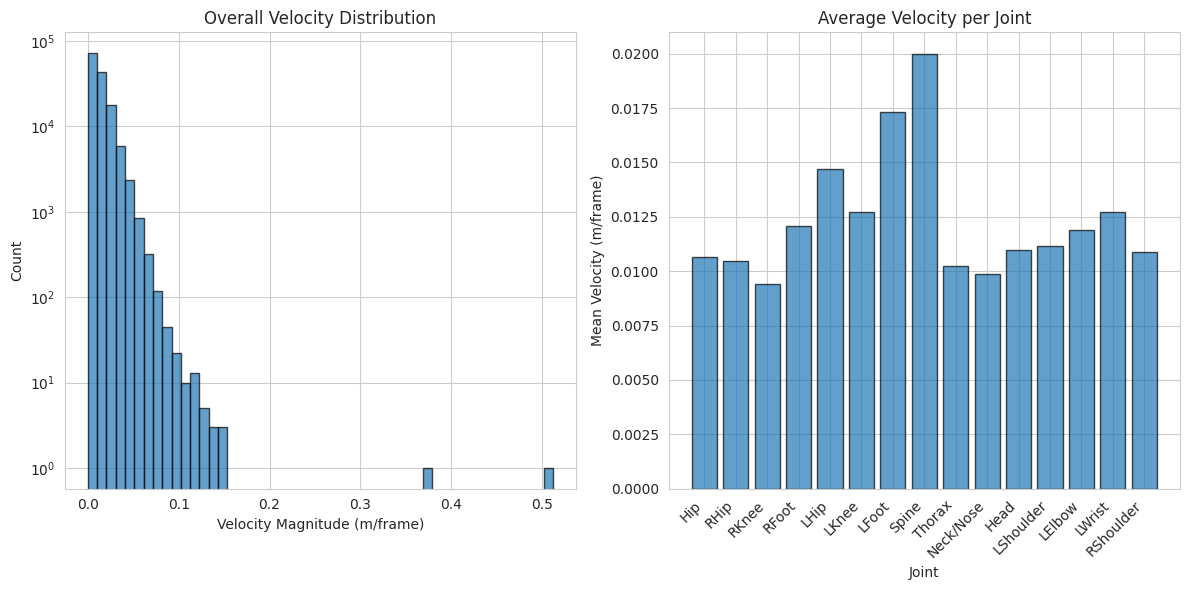

In [27]:
# Plot velocity distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(velocity_magnitudes.flatten(), bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Velocity Magnitude (m/frame)')
plt.ylabel('Count')
plt.title('Overall Velocity Distribution')
plt.yscale('log')

plt.subplot(1, 2, 2)
plt.bar(range(num_joints), velocity_stats_df['Mean_vel'], 
        edgecolor='black', alpha=0.7)
plt.xticks(range(num_joints), joint_names, rotation=45, ha='right')
plt.xlabel('Joint')
plt.ylabel('Mean Velocity (m/frame)')
plt.title('Average Velocity per Joint')

plt.tight_layout()
plt.show()

### Action Duration
Analyze sequence lengths and durations per action category.

In [29]:
# Add base action and duration to dataframe
df_sequences['base_action'] = df_sequences['action'].apply(
    lambda x: ' '.join(x.split()[:-2])
)
df_sequences['duration_sec'] = df_sequences['length'] / frame_rate

# Statistics per action
action_duration_stats = df_sequences.groupby('base_action')['duration_sec'].agg([
    'count', 'mean', 'std', 'min', 'max'
]).round(2)

action_duration_stats.columns = ['Count', 'Mean_sec', 'Std_sec', 'Min_sec', 'Max_sec']

print("Duration Statistics per Action:")
print(action_duration_stats)

Duration Statistics per Action:
             Count  Mean_sec  Std_sec  Min_sec  Max_sec
base_action                                            
Box             24      1.31     1.80     0.03     8.45
Gestures        21      1.34     1.98     0.03     6.77
Jog             10      3.42     2.76     0.27     6.62
ThrowCatch      11      1.55     1.72     0.03     5.22
Walking         11      4.44     3.30     0.22    10.22


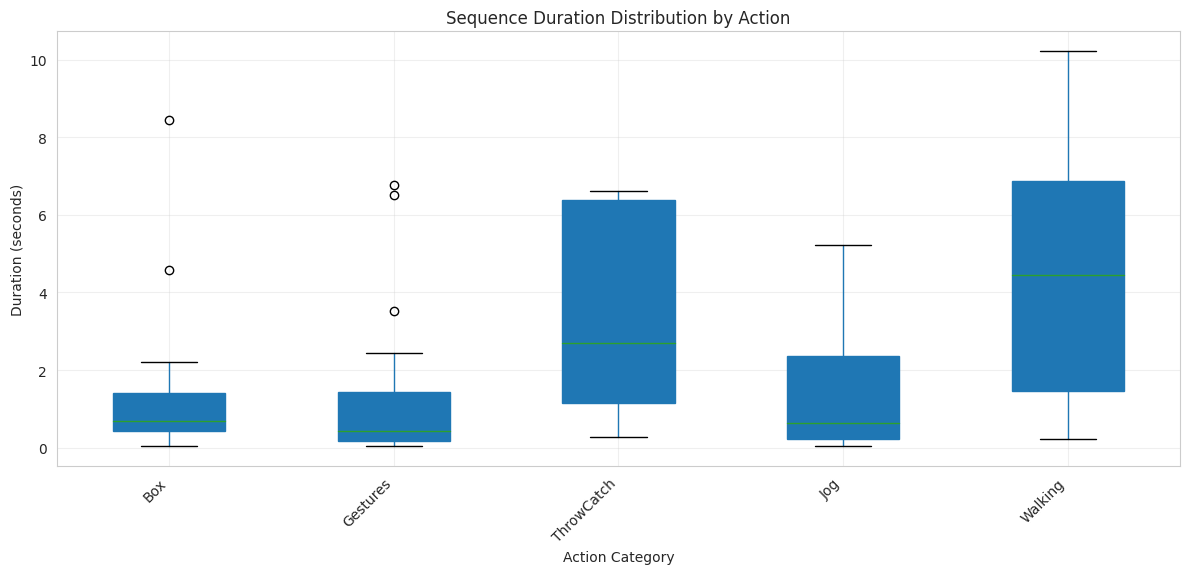

In [30]:
# Box plot of durations by action
plt.figure(figsize=(12, 6))

action_order = df_sequences.groupby('base_action')['duration_sec'].mean().sort_values().index

df_sequences.boxplot(column='duration_sec', by='base_action', 
                     ax=plt.gca(), 
                     positions=range(len(action_order)),
                     patch_artist=True)

plt.xticks(range(len(action_order)), action_order, rotation=45, ha='right')
plt.xlabel('Action Category')
plt.ylabel('Duration (seconds)')
plt.title('Sequence Duration Distribution by Action')
plt.suptitle('')  # Remove default title
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Outlier Detection
Identify sequences with anomalous position or velocity values using statistical methods.

In [31]:
# Compute z-scores for positions
position_means = all_positions.mean(axis=0)
position_stds = all_positions.std(axis=0)

z_scores = np.abs((all_positions - position_means) / (position_stds + 1e-10))

# Flag outliers (|z| > 3)
outlier_threshold = 3
position_outliers = z_scores > outlier_threshold

# Count outliers per sequence
outlier_counts = []
frame_offset = 0

for subject in subjects:
    for action, sequence in data_dict[subject].items():
        seq_len = len(sequence)
        seq_outliers = position_outliers[frame_offset:frame_offset + seq_len]
        outlier_count = seq_outliers.sum()
        
        outlier_counts.append({
            'subject': subject,
            'action': action,
            'length': seq_len,
            'outlier_count': outlier_count,
            'outlier_percentage': 100 * outlier_count / (seq_len * num_joints * 3)
        })
        
        frame_offset += seq_len

df_outliers = pd.DataFrame(outlier_counts)

print(f"Outlier Detection (|z-score| > {outlier_threshold}):")
print(f"  Total outlier values: {position_outliers.sum()}")
print(f"  Percentage: {100 * position_outliers.sum() / position_outliers.size:.4f}%")

Outlier Detection (|z-score| > 3):
  Total outlier values: 1416
  Percentage: 0.3286%


In [32]:
# Sort by outlier percentage
df_outliers_sorted = df_outliers.sort_values('outlier_percentage', ascending=False)

print("\nTop 10 sequences with most outliers:")
print(df_outliers_sorted.head(10).to_string(index=False))

# Flag sequences with >1% outliers
outlier_flagged = df_outliers[df_outliers['outlier_percentage'] > 1.0]
print(f"\nSequences with >1% outliers: {len(outlier_flagged)}")


Top 10 sequences with most outliers:
    subject           action  length  outlier_count  outlier_percentage
Validate/S2    Box 1 chunk10      32             80            5.555556
   Train/S3 Walking 1 chunk2      85             85            2.222222
   Train/S3 Walking 1 chunk0     393            393            2.222222
Validate/S3 Walking 1 chunk4     267            208            1.731169
   Train/S3     Box 1 chunk2      45             22            1.086420
   Train/S3     Box 1 chunk0     274            114            0.924574
   Train/S3     Box 1 chunk6      84             33            0.873016
Validate/S3     Box 1 chunk0     507            195            0.854701
   Train/S2     Box 1 chunk2      74             26            0.780781
   Train/S3     Jog 1 chunk0     353             80            0.503620

Sequences with >1% outliers: 5


In [33]:
# Velocity-based outlier detection
velocity_threshold = velocity_magnitudes.mean() + 3 * velocity_magnitudes.std()

print(f"Velocity outlier threshold: {velocity_threshold:.4f} m/frame")

velocity_outlier_sequences = []
vel_frame_offset = 0

for subject in subjects:
    for action, sequence in data_dict[subject].items():
        if len(sequence) > 1:
            seq_len = len(sequence) - 1  # velocities have one less frame
            seq_vels = velocity_magnitudes[vel_frame_offset:vel_frame_offset + seq_len]
            
            max_vel = seq_vels.max()
            outlier_vel_count = (seq_vels > velocity_threshold).sum()
            
            velocity_outlier_sequences.append({
                'subject': subject,
                'action': action,
                'max_velocity': max_vel,
                'outlier_vel_frames': outlier_vel_count
            })
            
            vel_frame_offset += seq_len

df_vel_outliers = pd.DataFrame(velocity_outlier_sequences)
df_vel_outliers_sorted = df_vel_outliers.sort_values('max_velocity', ascending=False)

print("\nTop 10 sequences with highest velocities:")
print(df_vel_outliers_sorted.head(10).to_string(index=False))

Velocity outlier threshold: 0.0472 m/frame

Top 10 sequences with highest velocities:
    subject              action  max_velocity  outlier_vel_frames
Validate/S3    Walking 1 chunk4      0.511920                  84
Validate/S3        Box 1 chunk0      0.147769                 261
Validate/S1        Jog 1 chunk0      0.139438                 109
   Train/S3        Box 1 chunk0      0.132538                 167
   Train/S3        Box 1 chunk4      0.105353                   9
Validate/S2       Box 1 chunk10      0.100125                  16
   Train/S3        Box 1 chunk6      0.082509                  61
Validate/S3        Jog 1 chunk0      0.073721                 252
   Train/S3        Jog 1 chunk0      0.073701                 309
   Train/S1 ThrowCatch 1 chunk1      0.072105                   7


In [34]:
# Combine outlier information
df_combined = df_outliers.merge(
    df_vel_outliers[['subject', 'action', 'max_velocity', 'outlier_vel_frames']],
    on=['subject', 'action'],
    how='left'
)

# Flag sequences with issues
df_combined['has_issues'] = (
    (df_combined['outlier_percentage'] > 1.0) | 
    (df_combined['outlier_vel_frames'] > 0)
)

flagged_for_review = df_combined[df_combined['has_issues']]

print(f"Sequences flagged for review: {len(flagged_for_review)}")
print("\nFlagged sequences:")
print(flagged_for_review[['subject', 'action', 'outlier_percentage', 
                          'max_velocity', 'outlier_vel_frames']].to_string(index=False))

Sequences flagged for review: 35

Flagged sequences:
    subject              action  outlier_percentage  max_velocity  outlier_vel_frames
   Train/S1        Box 1 chunk7            0.000000      0.069598                  18
   Train/S1        Jog 1 chunk1            0.000000      0.057886                  24
   Train/S1        Jog 1 chunk3            0.000000      0.057268                   9
   Train/S1 ThrowCatch 1 chunk1            0.000000      0.072105                   7
   Train/S1    Walking 1 chunk0            0.000000      0.052732                  23
   Train/S2        Box 1 chunk0            0.000000      0.059311                  19
   Train/S2        Box 1 chunk2            0.780781      0.066154                  16
   Train/S2        Box 1 chunk4            0.000000      0.058165                  10
   Train/S2        Jog 1 chunk0            0.106353      0.063597                 139
   Train/S2 ThrowCatch 1 chunk1            0.000000      0.059800                   3
 

### Time Series: Flagged Sequences with Anomalies
Visualize outlier patterns in time series for flagged sequences.

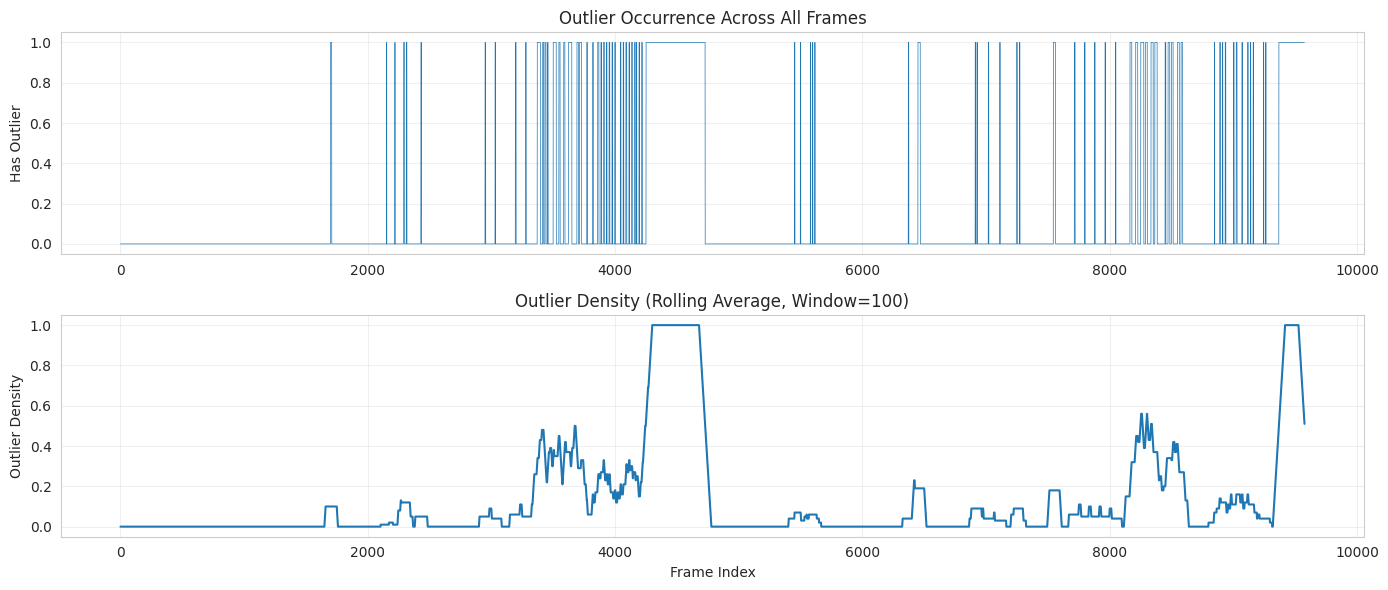

In [35]:
# Visualize outlier patterns over time
outlier_per_frame = position_outliers.any(axis=(1, 2)).astype(int)

plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(outlier_per_frame, linewidth=0.5)
plt.ylabel('Has Outlier')
plt.title('Outlier Occurrence Across All Frames')
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
# Rolling sum to show density
window_size = 100
outlier_density = np.convolve(outlier_per_frame, np.ones(window_size)/window_size, mode='same')
plt.plot(outlier_density)
plt.xlabel('Frame Index')
plt.ylabel('Outlier Density')
plt.title(f'Outlier Density (Rolling Average, Window={window_size})')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

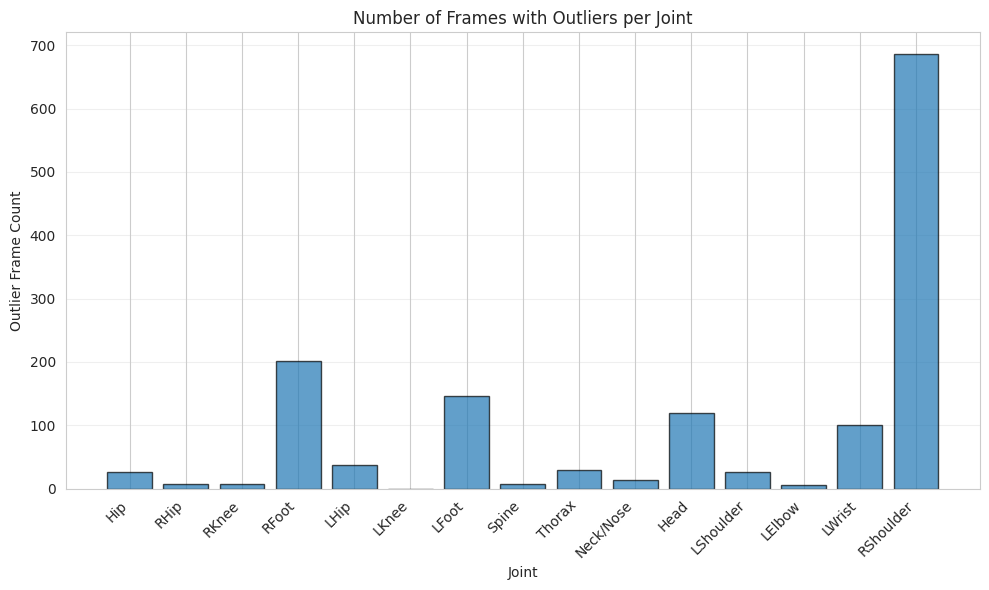


Outliers per joint:
  Hip         : 26
  RHip        : 8
  RKnee       : 8
  RFoot       : 201
  LHip        : 38
  LKnee       : 0
  LFoot       : 146
  Spine       : 8
  Thorax      : 29
  Neck/Nose   : 13
  Head        : 119
  LShoulder   : 27
  LElbow      : 6
  LWrist      : 101
  RShoulder   : 686


In [36]:
# Count outliers per joint
outliers_per_joint = position_outliers.any(axis=2).sum(axis=0)

plt.figure(figsize=(10, 6))
plt.bar(range(num_joints), outliers_per_joint, edgecolor='black', alpha=0.7)
plt.xticks(range(num_joints), joint_names, rotation=45, ha='right')
plt.xlabel('Joint')
plt.ylabel('Outlier Frame Count')
plt.title('Number of Frames with Outliers per Joint')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\nOutliers per joint:")
for joint_idx, count in enumerate(outliers_per_joint):
    print(f"  {joint_names[joint_idx]:12s}: {count}")

## Sample Visualizations
Visualize 3D skeleton trajectories and prepare animated sequences for different actions.

In [37]:
# Select one sequence per base action for visualization
sample_sequences = {}

for base_action in base_actions:
    # Find first sequence for this action
    for subject in subjects:
        for action, sequence in data_dict[subject].items():
            if action.startswith(base_action):
                sample_sequences[base_action] = {
                    'subject': subject,
                    'action': action,
                    'sequence': sequence
                }
                break
        if base_action in sample_sequences:
            break

print(f"Selected {len(sample_sequences)} sample sequences:")
for base_action, info in sample_sequences.items():
    print(f"  {base_action:15s}: {info['subject']:15s} - {info['action']:30s} ({info['sequence'].shape[0]} frames)")

Selected 5 sample sequences:
  Box            : Train/S1        - Box 1 chunk1                   (28 frames)
  Gestures       : Train/S1        - Gestures 1 chunk0              (406 frames)
  Jog            : Train/S1        - Jog 1 chunk1                   (90 frames)
  ThrowCatch     : Train/S1        - ThrowCatch 1 chunk1            (217 frames)
  Walking        : Train/S1        - Walking 1 chunk0               (613 frames)


In [38]:
def plot_skeleton_trajectory(sequence, title, frame_indices=None):
    """Plot 3D skeleton trajectory for selected frames."""
    if frame_indices is None:
        # Select evenly spaced frames
        num_frames_to_show = min(5, len(sequence))
        frame_indices = np.linspace(0, len(sequence)-1, num_frames_to_show, dtype=int)
    
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(frame_indices)))
    
    for idx, frame_idx in enumerate(frame_indices):
        frame = sequence[frame_idx]
        
        # Plot joints
        ax.scatter(frame[:, 0], frame[:, 1], frame[:, 2], 
                  c=[colors[idx]], s=50, alpha=0.6)
        
        # Plot skeleton connections
        for connection in skeleton_connections:
            parent, child = connection
            points = frame[[parent, child]]
            ax.plot(points[:, 0], points[:, 1], points[:, 2], 
                   c=colors[idx], alpha=0.4, linewidth=2)
    
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    ax.set_title(title)
    
    # Equal aspect ratio
    max_range = np.array([
        frame[:, 0].max() - frame[:, 0].min(),
        frame[:, 1].max() - frame[:, 1].min(),
        frame[:, 2].max() - frame[:, 2].min()
    ]).max() / 2.0
    
    mid_x = (frame[:, 0].max() + frame[:, 0].min()) * 0.5
    mid_y = (frame[:, 1].max() + frame[:, 1].min()) * 0.5
    mid_z = (frame[:, 2].max() + frame[:, 2].min()) * 0.5
    
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    
    plt.tight_layout()
    return fig, ax

print("Trajectory plotting function defined.")

Trajectory plotting function defined.


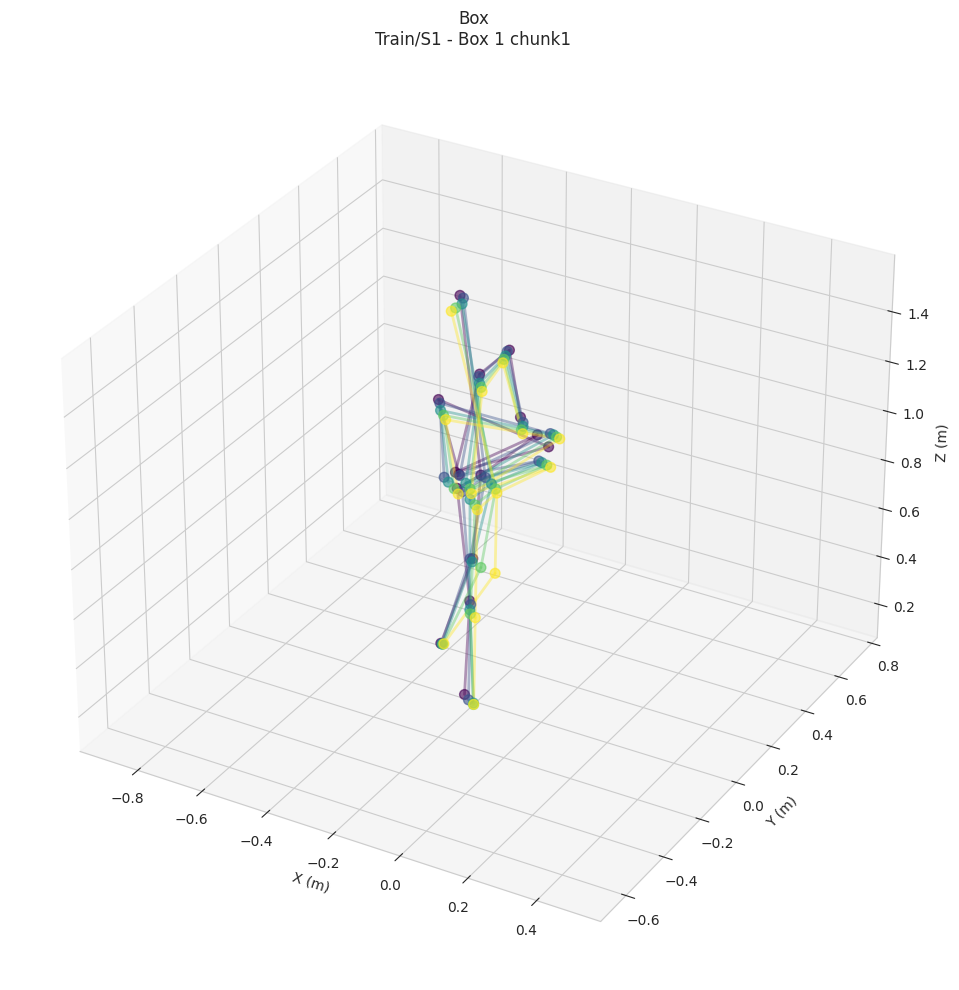

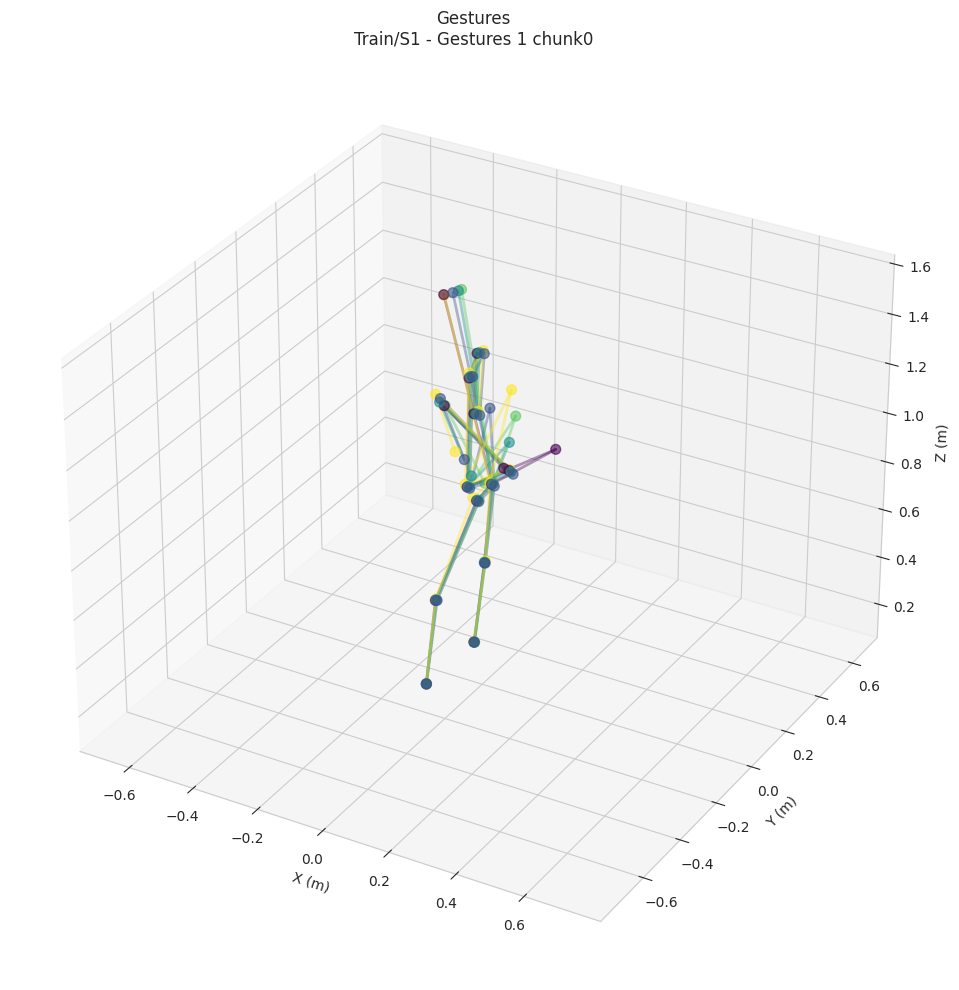

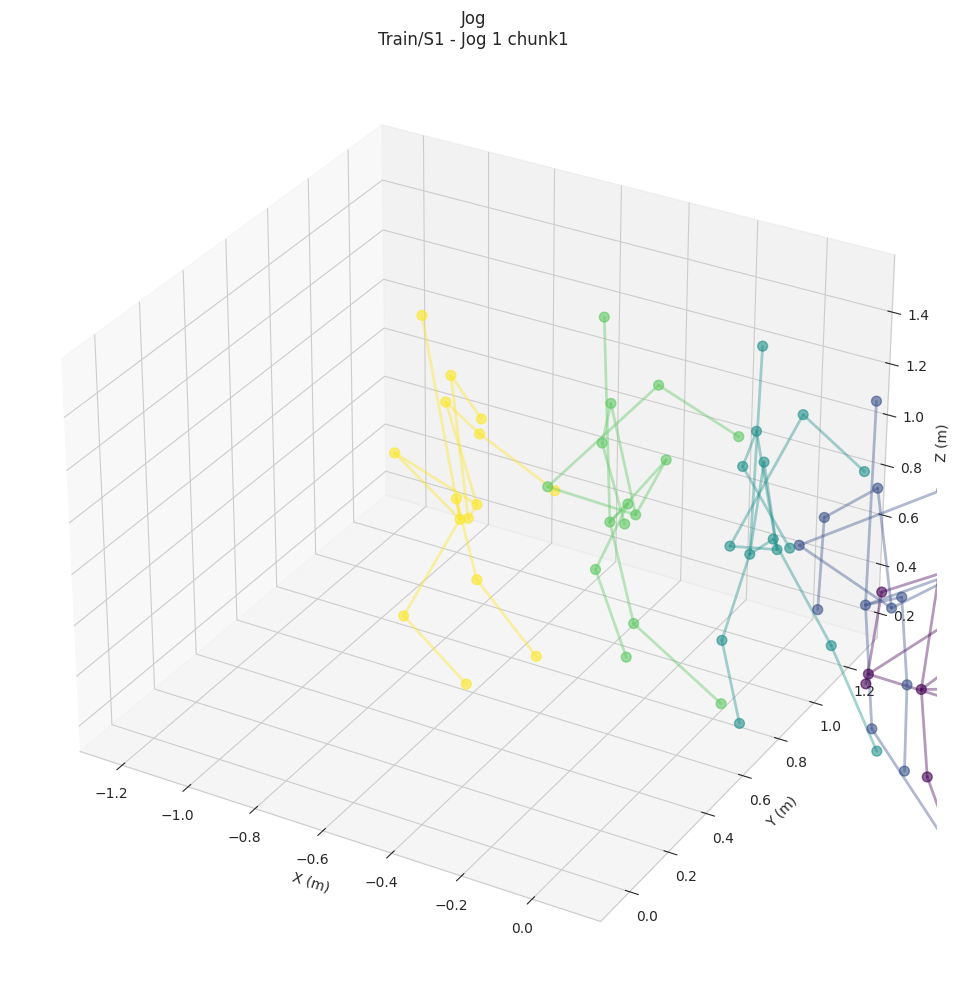

In [39]:
# Visualize trajectories for a few actions
actions_to_visualize = list(sample_sequences.keys())[:3]  # First 3 actions

for base_action in actions_to_visualize:
    info = sample_sequences[base_action]
    sequence = info['sequence']
    title = f"{base_action}\n{info['subject']} - {info['action']}"
    
    fig, ax = plot_skeleton_trajectory(sequence, title)
    plt.show()

### Prepare Animation Data for Multiple Actions
Set up data structures for creating animated sequences.

In [40]:
# Prepare animation data
animation_data = {}

for base_action, info in list(sample_sequences.items())[:4]:  # First 4 actions
    sequence = info['sequence']
    
    # Downsample if sequence is too long
    if len(sequence) > 120:
        indices = np.linspace(0, len(sequence)-1, 120, dtype=int)
        sequence = sequence[indices]
    
    animation_data[base_action] = {
        'sequence': sequence,
        'subject': info['subject'],
        'action': info['action'],
        'num_frames': len(sequence)
    }

print("Animation data prepared:")
for action, data in animation_data.items():
    print(f"  {action:15s}: {data['num_frames']} frames")

Animation data prepared:
  Box            : 28 frames
  Gestures       : 120 frames
  Jog            : 90 frames
  ThrowCatch     : 120 frames


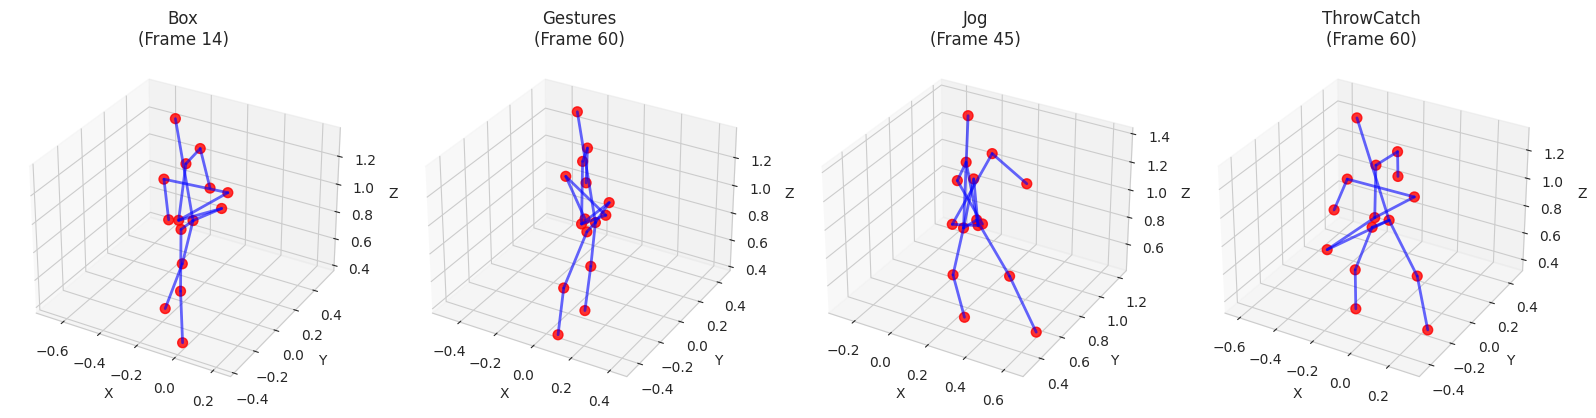

In [41]:
# Plot single frame from each action
fig = plt.figure(figsize=(16, 4))

for idx, (base_action, data) in enumerate(animation_data.items(), 1):
    ax = fig.add_subplot(1, 4, idx, projection='3d')
    
    # Use middle frame
    frame_idx = len(data['sequence']) // 2
    frame = data['sequence'][frame_idx]
    
    # Plot joints
    ax.scatter(frame[:, 0], frame[:, 1], frame[:, 2], 
              c='red', s=50, alpha=0.8)
    
    # Plot skeleton
    for connection in skeleton_connections:
        parent, child = connection
        points = frame[[parent, child]]
        ax.plot(points[:, 0], points[:, 1], points[:, 2], 
               'b-', linewidth=2, alpha=0.6)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f"{base_action}\n(Frame {frame_idx})")
    
    # Set equal aspect ratio
    max_range = 0.5
    mid_x = frame[:, 0].mean()
    mid_y = frame[:, 1].mean()
    mid_z = frame[:, 2].mean()
    
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

plt.tight_layout()
plt.show()

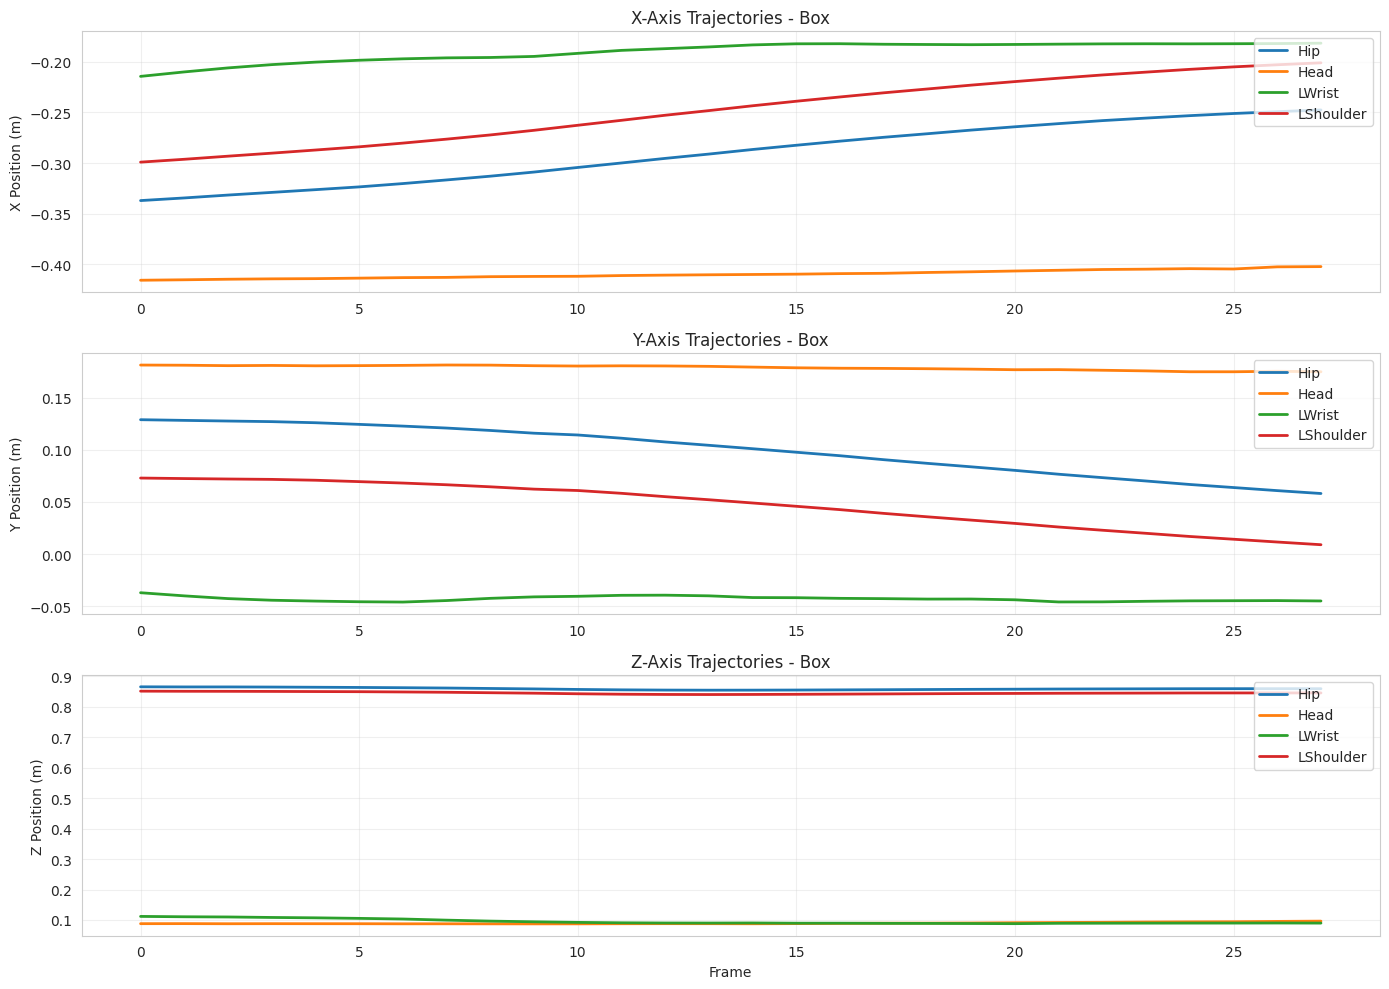

In [44]:
# Plot joint trajectories over time
sample_action = list(animation_data.keys())[0]
sample_seq = animation_data[sample_action]['sequence']

# Select joints to track (only from available 15 joints)
joints_to_track = ['Hip', 'Head', 'LWrist', 'LShoulder']
joint_indices_to_track = [joint_names.index(j) for j in joints_to_track]

fig, axes = plt.subplots(3, 1, figsize=(14, 10))
coords = ['X', 'Y', 'Z']

for coord_idx, (ax, coord_name) in enumerate(zip(axes, coords)):
    for joint_idx, joint_name in zip(joint_indices_to_track, joints_to_track):
        trajectory = sample_seq[:, joint_idx, coord_idx]
        ax.plot(trajectory, label=joint_name, linewidth=2)
    
    ax.set_ylabel(f'{coord_name} Position (m)')
    ax.set_title(f'{coord_name}-Axis Trajectories - {sample_action}')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Frame')
plt.tight_layout()
plt.show()

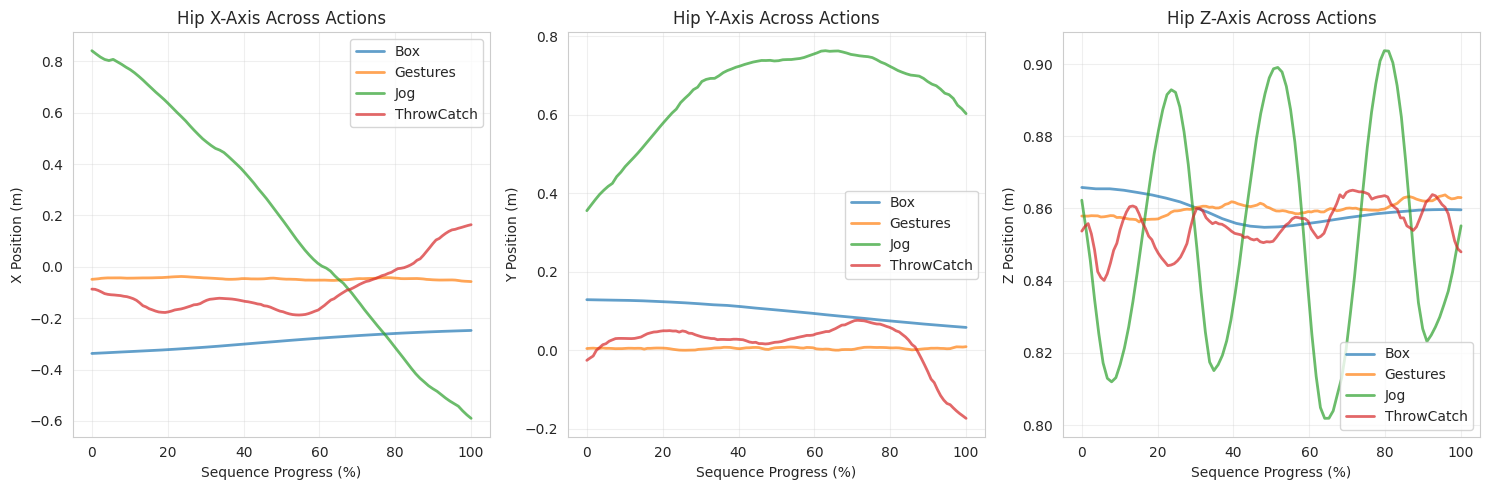

In [43]:
# Compare hip motion across different actions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
coords = ['X', 'Y', 'Z']
hip_idx = 0  # Hip joint

for coord_idx, (ax, coord_name) in enumerate(zip(axes, coords)):
    for action_name, data in animation_data.items():
        sequence = data['sequence']
        trajectory = sequence[:, hip_idx, coord_idx]
        
        # Normalize frame indices to percentage
        frame_pct = np.linspace(0, 100, len(trajectory))
        ax.plot(frame_pct, trajectory, label=action_name, linewidth=2, alpha=0.7)
    
    ax.set_xlabel('Sequence Progress (%)')
    ax.set_ylabel(f'{coord_name} Position (m)')
    ax.set_title(f'Hip {coord_name}-Axis Across Actions')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Duplicate & Redundancy Check
Identify similar or duplicate sequences using cosine similarity of feature vectors.

In [45]:
# Compute feature vectors for each sequence
feature_vectors = []
sequence_ids = []

for subject in subjects:
    for action, sequence in data_dict[subject].items():
        # Features: mean and std of positions for each joint
        mean_positions = sequence.mean(axis=0).flatten()  # (15*3,)
        std_positions = sequence.std(axis=0).flatten()    # (15*3,)
        
        # Combine features
        features = np.concatenate([mean_positions, std_positions])
        
        feature_vectors.append(features)
        sequence_ids.append(f"{subject}_{action}")

feature_vectors = np.array(feature_vectors)

print(f"Feature vectors shape: {feature_vectors.shape}")
print(f"Number of sequences: {len(sequence_ids)}")
print(f"Features per sequence: {feature_vectors.shape[1]}")

Feature vectors shape: (77, 90)
Number of sequences: 77
Features per sequence: 90


In [46]:
# Compute cosine similarity matrix
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(feature_vectors)

print(f"Similarity matrix shape: {similarity_matrix.shape}")
print(f"Similarity range: [{similarity_matrix.min():.3f}, {similarity_matrix.max():.3f}]")

# Set diagonal to 0 to ignore self-similarity
np.fill_diagonal(similarity_matrix, 0)

print(f"Max similarity (excluding diagonal): {similarity_matrix.max():.3f}")

Similarity matrix shape: (77, 77)
Similarity range: [0.070, 1.000]
Max similarity (excluding diagonal): 1.000


In [47]:
# Find near-duplicate pairs
similarity_threshold = 0.95
near_duplicates = []

for i in range(len(sequence_ids)):
    for j in range(i + 1, len(sequence_ids)):
        if similarity_matrix[i, j] > similarity_threshold:
            near_duplicates.append({
                'sequence_1': sequence_ids[i],
                'sequence_2': sequence_ids[j],
                'similarity': similarity_matrix[i, j]
            })

df_duplicates = pd.DataFrame(near_duplicates)

print(f"Near-duplicate pairs (similarity > {similarity_threshold}):")
print(f"  Total pairs: {len(near_duplicates)}")

if len(near_duplicates) > 0:
    print("\nNear-duplicate pairs:")
    print(df_duplicates.sort_values('similarity', ascending=False).to_string(index=False))
else:
    print("\nNo near-duplicates found.")

Near-duplicate pairs (similarity > 0.95):
  Total pairs: 763

Near-duplicate pairs:
                      sequence_1                       sequence_2  similarity
      Train/S3_Gestures 1 chunk7       Train/S3_Gestures 1 chunk9    0.999969
      Train/S3_Gestures 1 chunk3       Train/S3_Gestures 1 chunk5    0.999946
      Train/S3_Gestures 1 chunk1       Train/S3_Gestures 1 chunk3    0.999888
      Train/S3_Gestures 1 chunk3       Train/S3_Gestures 1 chunk7    0.999876
      Train/S3_Gestures 1 chunk5       Train/S3_Gestures 1 chunk7    0.999870
   Validate/S3_Gestures 1 chunk2    Validate/S3_Gestures 1 chunk8    0.999858
      Train/S1_Gestures 1 chunk0    Validate/S1_Gestures 1 chunk0    0.999855
      Train/S3_Gestures 1 chunk1       Train/S3_Gestures 1 chunk9    0.999835
      Train/S3_Gestures 1 chunk3       Train/S3_Gestures 1 chunk9    0.999824
      Train/S3_Gestures 1 chunk1       Train/S3_Gestures 1 chunk7    0.999812
      Train/S3_Gestures 1 chunk1       Train/S3_Gestures 1

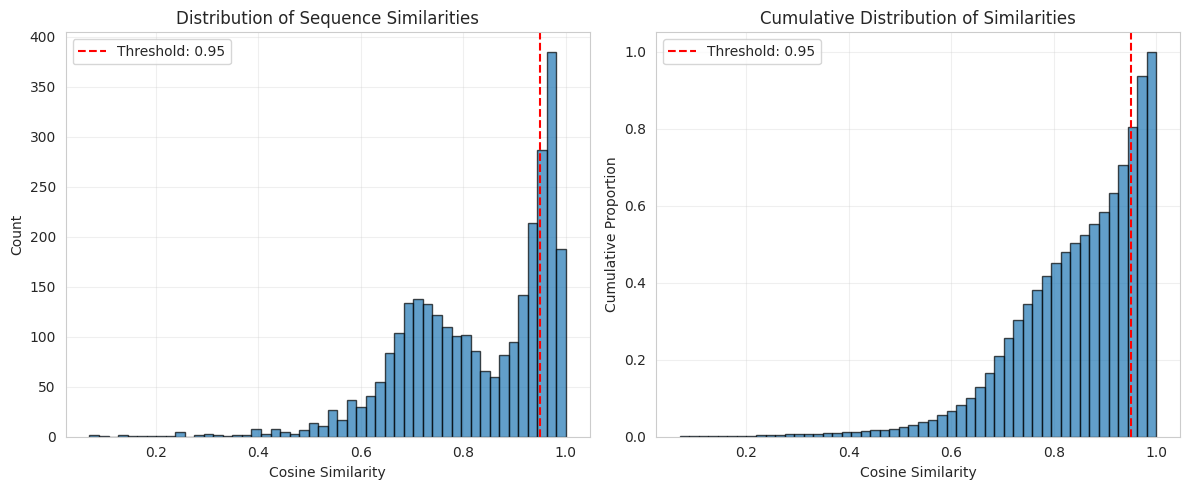


Similarity statistics:
  Mean: 0.823
  Median: 0.848
  Std: 0.145
  Pairs above threshold: 763


In [48]:
# Plot similarity distribution
upper_triangle = similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(upper_triangle, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Cosine Similarity')
plt.ylabel('Count')
plt.title('Distribution of Sequence Similarities')
plt.axvline(similarity_threshold, color='red', linestyle='--', 
            label=f'Threshold: {similarity_threshold}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(upper_triangle, bins=50, edgecolor='black', alpha=0.7, cumulative=True, density=True)
plt.xlabel('Cosine Similarity')
plt.ylabel('Cumulative Proportion')
plt.title('Cumulative Distribution of Similarities')
plt.axvline(similarity_threshold, color='red', linestyle='--', 
            label=f'Threshold: {similarity_threshold}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nSimilarity statistics:")
print(f"  Mean: {upper_triangle.mean():.3f}")
print(f"  Median: {np.median(upper_triangle):.3f}")
print(f"  Std: {upper_triangle.std():.3f}")
print(f"  Pairs above threshold: {(upper_triangle > similarity_threshold).sum()}")

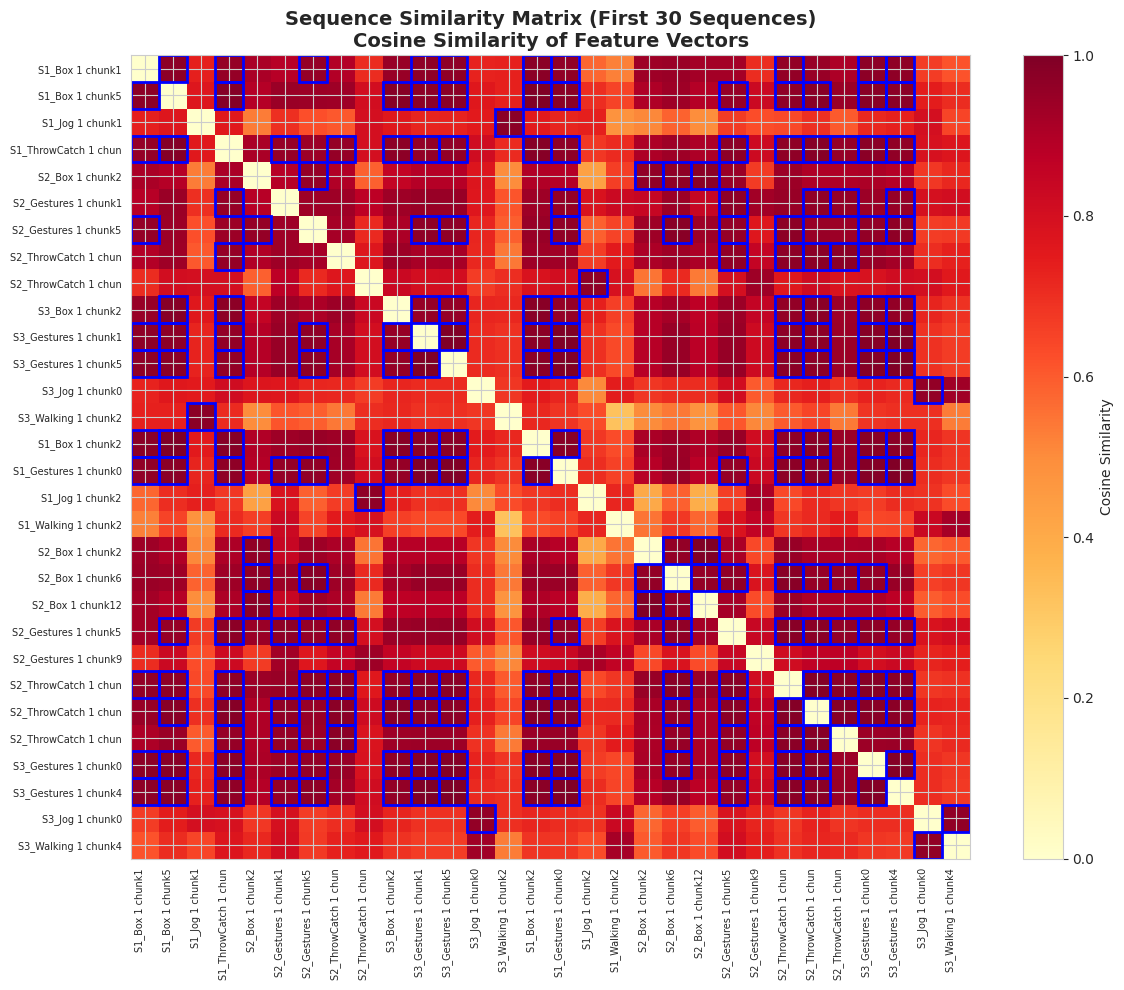

Blue boxes indicate near-duplicates (similarity > 0.95)


In [49]:
# Visualize similarity matrix (sample due to size)
sample_size = min(30, len(sequence_ids))
sample_indices = np.linspace(0, len(sequence_ids)-1, sample_size, dtype=int)
sample_ids = [sequence_ids[i] for i in sample_indices]
sample_matrix = similarity_matrix[np.ix_(sample_indices, sample_indices)]

fig, ax = plt.subplots(figsize=(12, 10))

im = ax.imshow(sample_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)

# Set ticks
ax.set_xticks(range(len(sample_ids)))
ax.set_yticks(range(len(sample_ids)))
ax.set_xticklabels([sid.split('/')[-1][:20] for sid in sample_ids], 
                    rotation=90, ha='right', fontsize=7)
ax.set_yticklabels([sid.split('/')[-1][:20] for sid in sample_ids], fontsize=7)

ax.set_title(f'Sequence Similarity Matrix (First {sample_size} Sequences)\n'
             f'Cosine Similarity of Feature Vectors',
             fontsize=14, fontweight='bold')

plt.colorbar(im, ax=ax, label='Cosine Similarity')

# Mark high similarity pairs in sample
sample_id_set = set(sample_ids)
for dup in near_duplicates:
    if dup['sequence_1'] in sample_id_set and dup['sequence_2'] in sample_id_set:
        i = sample_ids.index(dup['sequence_1'])
        j = sample_ids.index(dup['sequence_2'])
        ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, 
                                   fill=False, edgecolor='blue', linewidth=2))
        ax.add_patch(plt.Rectangle((i-0.5, j-0.5), 1, 1, 
                                   fill=False, edgecolor='blue', linewidth=2))

plt.tight_layout()
plt.show()

print(f"Blue boxes indicate near-duplicates (similarity > {similarity_threshold})")

Similarity Analysis:

Within same subject:
  Mean: 0.842
  Median: 0.892
  Max: 1.000

Across different subjects:
  Mean: 0.819
  Median: 0.840
  Max: 1.000


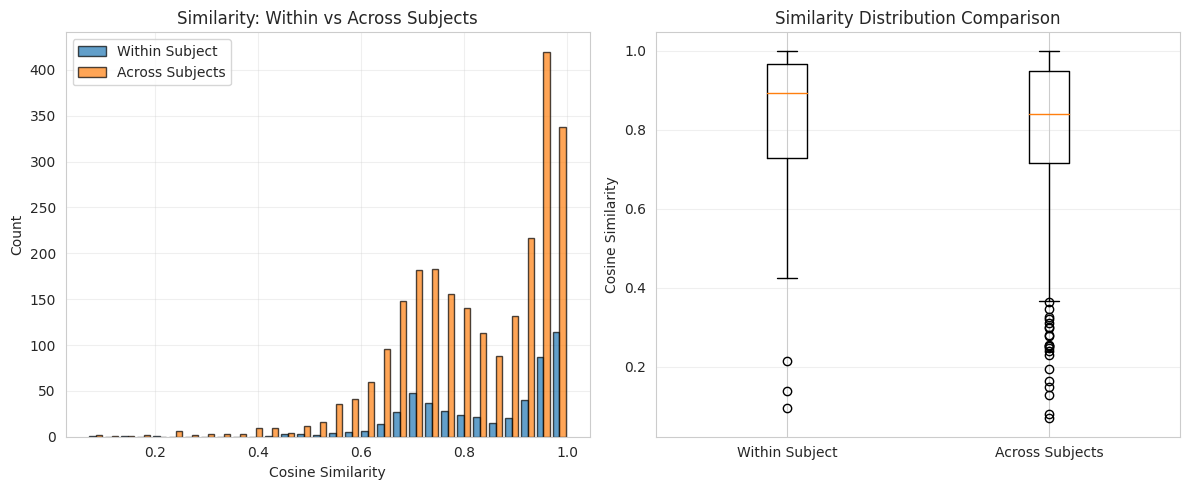

In [50]:
# Analyze similarity within vs across subjects
within_subject_sim = []
across_subject_sim = []

for i in range(len(sequence_ids)):
    for j in range(i + 1, len(sequence_ids)):
        subject_i = sequence_ids[i].split('_')[0]
        subject_j = sequence_ids[j].split('_')[0]
        
        if subject_i == subject_j:
            within_subject_sim.append(similarity_matrix[i, j])
        else:
            across_subject_sim.append(similarity_matrix[i, j])

print("Similarity Analysis:")
print(f"\nWithin same subject:")
print(f"  Mean: {np.mean(within_subject_sim):.3f}")
print(f"  Median: {np.median(within_subject_sim):.3f}")
print(f"  Max: {np.max(within_subject_sim):.3f}")

print(f"\nAcross different subjects:")
print(f"  Mean: {np.mean(across_subject_sim):.3f}")
print(f"  Median: {np.median(across_subject_sim):.3f}")
print(f"  Max: {np.max(across_subject_sim):.3f}")

# Plot comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist([within_subject_sim, across_subject_sim], bins=30, 
         label=['Within Subject', 'Across Subjects'], 
         edgecolor='black', alpha=0.7)
plt.xlabel('Cosine Similarity')
plt.ylabel('Count')
plt.title('Similarity: Within vs Across Subjects')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot([within_subject_sim, across_subject_sim], 
            labels=['Within Subject', 'Across Subjects'])
plt.ylabel('Cosine Similarity')
plt.title('Similarity Distribution Comparison')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [51]:
# Export summary statistics
summary_stats = {
    'Dataset': 'HumanEva-I',
    'Total_subjects': len(subjects),
    'Train_subjects': len(train_sequences),
    'Val_subjects': len(val_sequences),
    'Total_sequences': total_train + total_val,
    'Train_sequences': total_train,
    'Val_sequences': total_val,
    'Base_actions': len(base_actions),
    'Num_joints': num_joints,
    'Mean_seq_length': np.mean(sequence_lengths),
    'Total_frames': all_positions.shape[0],
    'Missing_values': 0,
    'Flagged_sequences': len(flagged_for_review),
    'Near_duplicates': len(near_duplicates),
    'Data_quality': 'Good' if len(flagged_for_review) == 0 else 'Review flagged'
}

df_summary = pd.DataFrame([summary_stats])
print("Dataset Summary Statistics:")
print(df_summary.T)

# Optionally save to CSV
# df_summary.T.to_csv('../data/humaneva_summary.csv', header=False)
# print("\nSummary saved to: ../data/humaneva_summary.csv")

Dataset Summary Statistics:
                                0
Dataset                HumanEva-I
Total_subjects                  6
Train_subjects                  3
Val_subjects                    3
Total_sequences                77
Train_sequences                35
Val_sequences                  42
Base_actions                    5
Num_joints                     15
Mean_seq_length        124.376623
Total_frames                 9577
Missing_values                  0
Flagged_sequences              35
Near_duplicates               763
Data_quality       Review flagged
